# QuipuNet: barcode reader

In [1]:
# install missing libs

!pip install tables

    100% |████████████████████████████████| 3.8MB 10.7MB/s 
    100% |████████████████████████████████| 163kB 30.3MB/s 


**Disclaimer**: this notebook was used for prototyping and research. Please forgive us occasional spelling mistakes and lack of detailed documentation.  


**In this notebook**: Load libraries and data; familiarise with typical events; prepare data for NN; setup NN model; train (or load the model from memory); evaluate the model



Aim to identify the barcodes on DNA carrier structure using NN methods. Detailed description available with the paper. 

<img src="images/complexity of DNA carrier signal.png" width="400">


In [2]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import matplotlib, seaborn
import h5py
import scipy
import sklearn
import time

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

# change for your QuipuNet forlder
folder_on_drive = "drive/My Drive/University/QuipuNet/"

# add python path to relavant library 
import sys
sys.path.insert(0, folder_on_drive) 



import Quipu
from Quipu.kerasHelpers import resetHistory, nextEpochNo
from Quipu.tools import normaliseLength
from Quipu import augment

import keras
from keras import layers
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Embedding
from keras.optimizers import SGD, Adam
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


In [0]:
# plot configuration 

%matplotlib inline
%config InlineBackend.figure_format='retina'

# general plotting config
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 10}
matplotlib.rc('font', **font)

In [4]:
# Load cleaned datasets



dataset =         pd.concat([ 
    pd.read_hdf(folder_on_drive + "data/dataset_part1.hdf5"),
    pd.read_hdf(folder_on_drive + "data/dataset_part2.hdf5")
])
datasetTestEven = pd.read_hdf(folder_on_drive + "data/datasetTestEven.hdf5")
datasetTestOdd =  pd.read_hdf(folder_on_drive + "data/datasetTestOdd.hdf5")
datasetTestMix =  pd.read_hdf(folder_on_drive + "data/datasetTestMix.hdf5")
datasetWithAntibodies =  pd.concat([ 
    pd.read_hdf(folder_on_drive + "data/datasetWithAntibodies_part1.hdf5"),
    pd.read_hdf(folder_on_drive + "data/datasetWithAntibodies_part2.hdf5")
])
datasetExtra =    pd.read_hdf(folder_on_drive + "data/datasetExtra.hdf5")

print("Fraction of used data: ", dataset.Filter.sum()/ len(dataset))

Fraction of used data:  0.7078922040423484


# Familiarize with the data



Blue = NBell could indentify; Orange = NBell did not indentify; Red = excluded by filtration step


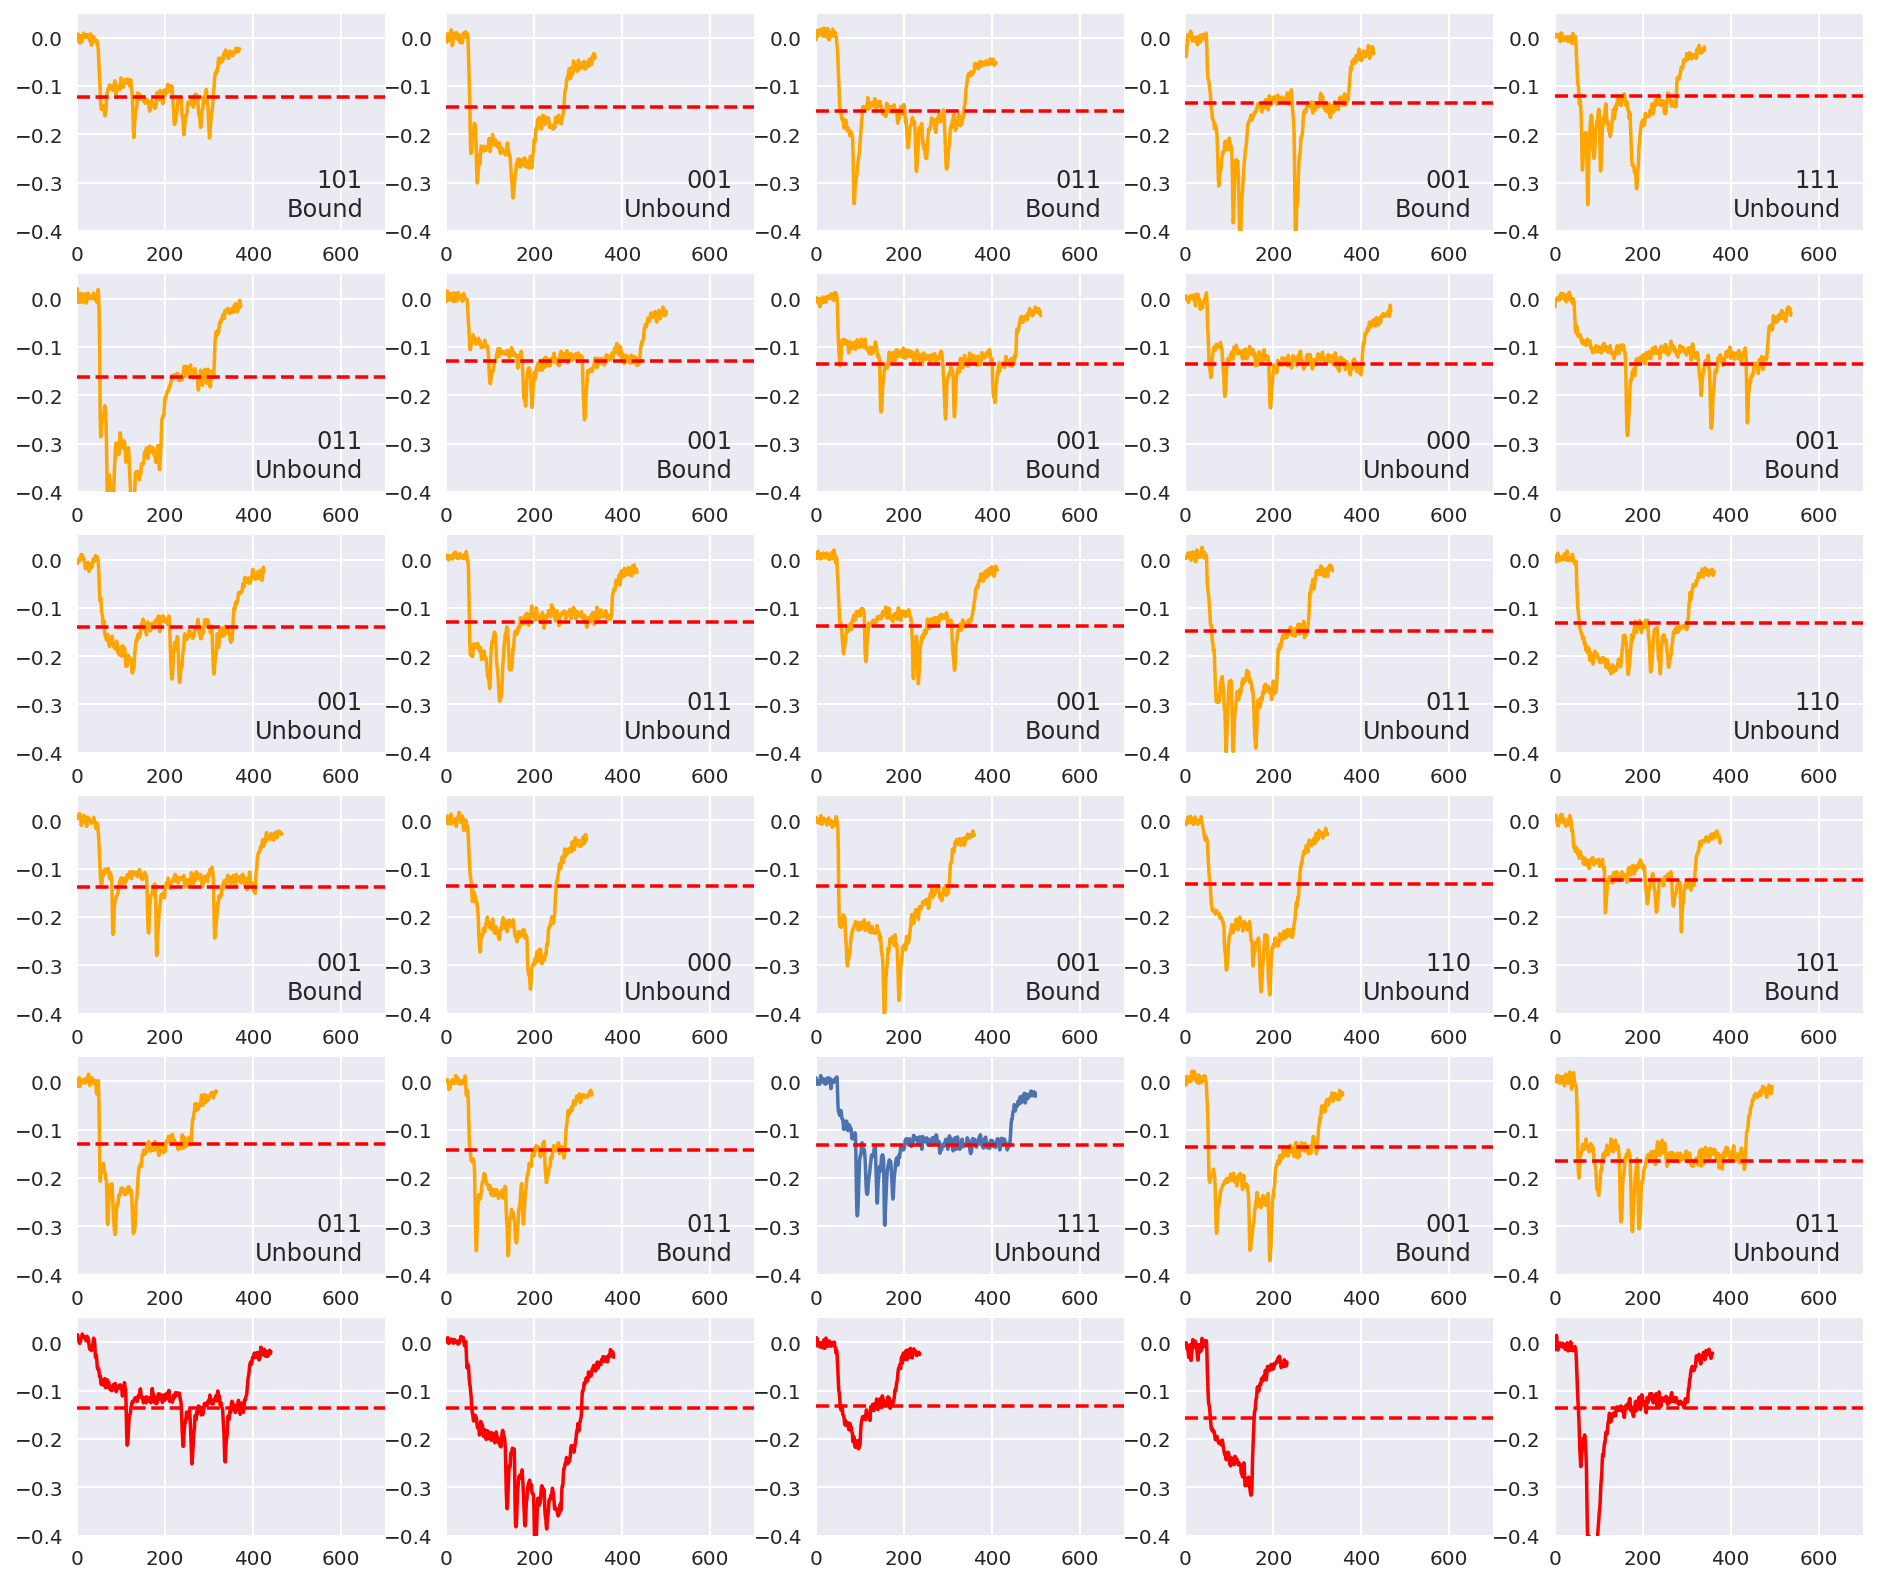

In [19]:
pyplot.figure(figsize=[16,14])

data = pd.concat([dataset, datasetWithAntibodies], ignore_index=True)

print("Blue = NBell could indentify; Orange = NBell did not indentify; Red = excluded by filtration step")

examples_included = data[data.Filter ].sample(5*5)
for i in range(5*5):
    one = examples_included.iloc[i]
    pyplot.subplot(5+1,5,i+1)
    if one.nbell_barcode < 8:
        pyplot.plot(one.trace)
    else:
        pyplot.plot(one.trace, color='orange')
    # labels
    pyplot.text(650.0, -0.31, one.barcode, fontsize=12, horizontalalignment='right')
    bound_label = "Bound" if one.Bound else "Unbound"
    pyplot.text(650.0, -0.37, bound_label, fontsize=12, horizontalalignment='right')
    pyplot.plot([0,700], [one.UnfoldedLevel]*2, 'r--')
    pyplot.ylim([-0.4, 0.05])
    pyplot.xlim([0, 700])
    
    
#pyplot.figure(figsize=[16,2.2])
examples_excluded = data[~data.Filter].sample(1*5)
for i in range(1*5):
    one = examples_excluded.iloc[i]
    pyplot.subplot(5+1,5,5*5+i+1)
    pyplot.plot(one.trace, color='red')
    pyplot.plot([0,700], [one.UnfoldedLevel]*2, 'r--')
    pyplot.ylim([-0.4, 0.05])
    pyplot.xlim([0, 700]) 

Here trace has padding in the beginning and the end, while pulse is the trimmed version. 

We will use traces as inputs to the NN. It can be safely used at 700, where the very few events longer than that will be trimmed at the end. No information will be lost since the trimming will happen on the padding.

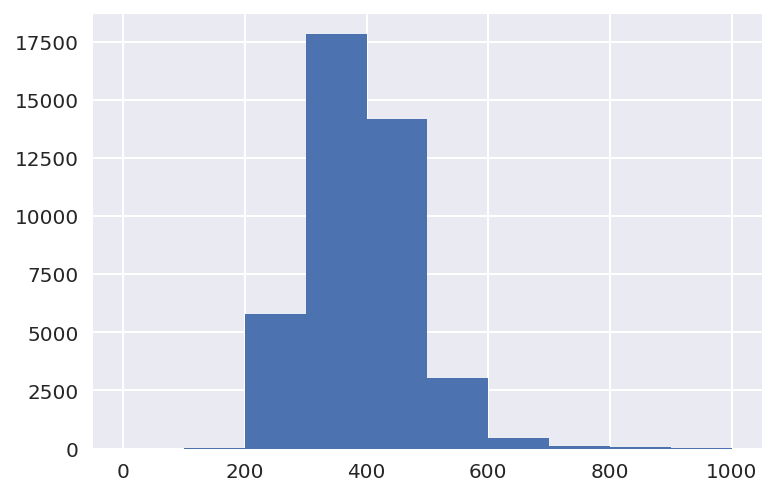

In [27]:
pyplot.hist( dataset.trace.apply(len), bins = 10, range=(0, 1000)) ;


### Weak correlations between nanopores

Figure below shows the unfolded event current level. It varies depending on the shape and size of the nanopore. This is very distinct signal and we do **not** want the NN to learn it. Therefore, we will normalise these events before feeding them into the NN.  

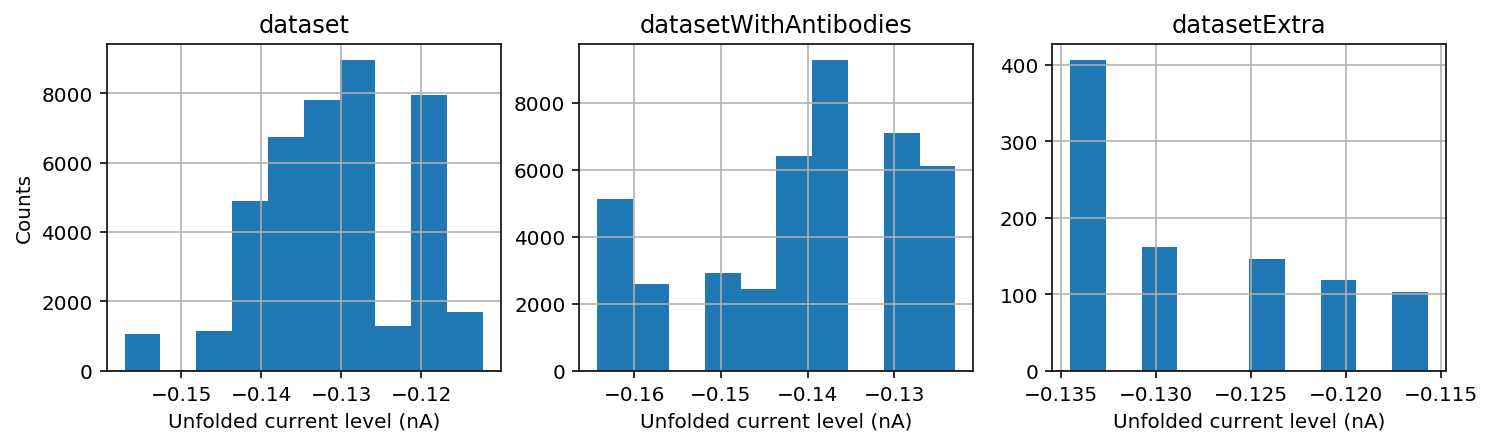

In [0]:
pyplot.figure(figsize=[12,3])
pyplot.subplot(1,3,1)
dataset.UnfoldedLevel.hist()
pyplot.title("dataset")
pyplot.xlabel("Unfolded current level (nA)")
pyplot.ylabel("Counts")
pyplot.subplot(1,3,2)
datasetWithAntibodies.UnfoldedLevel.hist()
pyplot.title("datasetWithAntibodies")
pyplot.xlabel("Unfolded current level (nA)")
pyplot.subplot(1,3,3)
datasetExtra.UnfoldedLevel.hist();
pyplot.title("datasetExtra")
pyplot.xlabel("Unfolded current level (nA)");

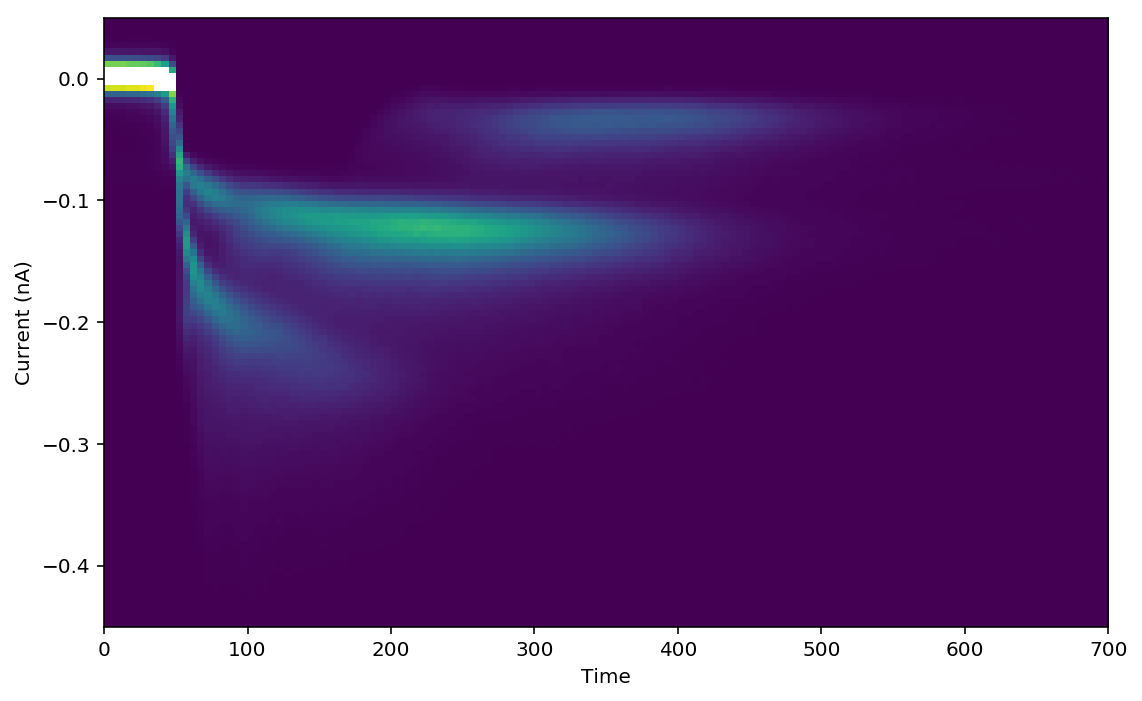

In [0]:
# Histogram of typical events

def addIndex(vec):
    "add index to a vector and zip"
    return np.array([np.arange(len(vec)), vec]).T

points = np.vstack( 
     list( map( addIndex, dataset.iloc[0:]["trace"] ) ) 
)


pyplot.figure( figsize=(9, 5.6))
pyplot.hist2d(points[:,0], points[:,1], 
                 bins=(70*2, 50*2),
                 range = [[0, 700], [-0.45, 0.05]],
                 cmax = 100000/4 # clip max
                );
pyplot.xlabel("Time")
pyplot.ylabel("Current (nA)");

---

# QuipuNet setup

## Hyperparametrs

Store hyper paramters in `hp` dictionary for easy modification later

In [0]:
# Hyperparameters

hp = {
    "traceLength" : 700,
    "traceTrim"   : 0,
    "barcodes"    : 8,        # distinct barcode count 
    "normalise_levels": True, # wherther to normalise experiments per batch before feetingh into NN
}


# barcode binnary encoding: int(barcode,2) 
# explicit for customistation 
barcodeEncoding = {
    "000" : 0,
    "001" : 1,
    "010" : 2,
    "011" : 3,
    "100" : 4,
    "101" : 5,
    "110" : 6,
    "111" : 7
}


## Helper functions

def prepareTraces(dataset):
    "trims, clips, and reformats the traces"
    traces = dataset.trace
    traces_uniform = traces.apply(lambda x: normaliseLength(x, length = hp["traceLength"], trim = hp["traceTrim"]))
    if hp["normalise_levels"]:
        traces_normalised =  - traces_uniform / dataset.UnfoldedLevel                     
        return np.vstack( traces_normalised )
    else:
        return np.vstack( traces_uniform )
    
def prepareLabels(dataset): 
    "prepare barcode labels for training and testing"
    # for barcodes we use one shot encoding
    return barcodeToOneHot( dataset.barcode )
 
    
    
## Covert between data types
# All should accept arrays OR singular values
    
# reverse encoding 
barcodeEncodingReverse = {v: k for k, v in barcodeEncoding.items()}
    
def barcodeToNumber(barcode):
    "translates the barcode string into number"
    if len(np.shape(barcode)) == 0 :
        return barcodeEncoding[barcode]
    elif len(np.shape(barcode)) == 1:
        fn = np.vectorize(lambda key: barcodeEncoding[key])
        return fn(barcode)
    elif len(np.shape(barcode)) == 2 and np.shape(barcode)[1] == 1:
        return barcodeToNumber(np.reshape(barcode, (-1,)))
    else:
        raise ValueError("Error: wrong input recieved: "+str(barcode))

def numberToBarcode(number):
    "number to barcode string"
    if len(np.shape(number)) == 0 :
        return barcodeEncodingReverse[number]
    elif len(np.shape(number)) == 1:
        fn = np.vectorize(lambda key: barcodeEncodingReverse[key])
        return fn(number)
    else:
        raise ValueError("Error: wrong input recieved: "+str(number))
    
def numberToOneHot(number):
    return keras.utils.to_categorical(number, num_classes= hp["barcodes"])
    
def oneHotToNumber(onehot):
    if np.shape(onehot) == (hp['barcodes'],):
        return np.argmax(onehot)
    elif len(np.shape(onehot)) == 2 and np.shape(onehot)[1] == hp['barcodes']:
        return np.apply_along_axis(arr=onehot, func1d=np.argmax, axis=1)
    else:
        raise ValueError("Error: wrong input recieved: "+str(onehot))

    
def barcodeToOneHot(barcode):
    "barcode string to catogory encoding aka One-Hot"
    return numberToOneHot( barcodeToNumber(barcode) )
    
def oneHotToBarcode(onehot):
    "catogory encoding aka One-Hot to barcode string"
    return numberToBarcode( oneHotToNumber(onehot) )
    
    
    
def labelToNumber(barcode):
    raise ValueError("Replace labelToNumber")
def numberToLabel(number):
    raise ValueError("Replace numberToLabel")
def toCategories(barcode):
    raise ValueError("Replace toCategories")
def fromCategories(x):
    raise ValueError("Replace fromCategories")
    
    
## tests

assert barcodeEncoding == {v: k for k, v in barcodeEncodingReverse.items()}, "There is non unique numbers in the `barcodeEncoding`"
assert hp["barcodes"] == len(barcodeEncoding), "Hyperparameter `barcodes` does not match the count in `barcodeEncoding`"

assert  numberToOneHot(1).shape == ( hp['barcodes'],)
assert  numberToOneHot([0,1,2]).shape == (3, hp['barcodes'])

assert oneHotToNumber([0,1,0,0,0,0,0,0]) == 1
assert np.all( oneHotToNumber(numberToOneHot([0,1,2])) == np.array([0,1,2])  )

assert barcodeToNumber('001') == 1
assert np.all( barcodeToNumber(['001', '000']) == np.array([1,0]) )

tmpTestBarcode = np.random.choice(list(barcodeEncoding.keys()))
assert numberToBarcode( barcodeToNumber( tmpTestBarcode ) ) == tmpTestBarcode
assert np.all( numberToBarcode( barcodeToNumber( [tmpTestBarcode]*4 ) ) == np.array([tmpTestBarcode]*4) )

assert oneHotToBarcode( barcodeToOneHot( tmpTestBarcode ) ) == tmpTestBarcode
assert np.all( oneHotToBarcode( barcodeToOneHot( [tmpTestBarcode]*4 ) ) == np.array([tmpTestBarcode]*4) )



## Independent test set

We need to have independent test sets? Our problem is high correlation between traces performed with the same nanopore (ie same baseline, length). This correlation could lead to QuipuNet over-fitting to secondary traits. To reduce chances for this happening we pick independent experiments that will never be used for training the NN.

List all experiments:

In [0]:
## Test set selection tool  

tmp = pd.concat([
    dataset[dataset.Filter][["barcode", "nanopore", "Bound"]].copy() ,
    datasetExtra[dataset.Filter][["barcode", "nanopore", "Bound"]].copy(),
    datasetWithAntibodies[datasetWithAntibodies.Filter][["barcode", "nanopore", "Bound"]].copy()
], ignore_index = True)
tmp = tmp.groupby(tmp.columns.tolist(),as_index=False).size()

tmp2 = pd.concat([
    dataset[dataset.nbell_barcode < 8][["barcode", "nanopore", "Bound"]].copy() 
], ignore_index = True)
tmp2 = tmp2.groupby(tmp2.columns.tolist(),as_index=False).size()

pd.DataFrame({
    "Full": tmp,
    "NBell": tmp2
})

In [0]:
# Select Test Set

#  Important: select independant nanopore experiments to avoid 
#  any correlations between the measurements. 

allDatasets = pd.concat([dataset , datasetExtra, datasetWithAntibodies],ignore_index = True)
allDatasets = allDatasets[allDatasets.Filter] # clear bad points

# Using one test set to develop the NN architecture and another one to report final results
# to reduce over-fitting to the test set


# selected the smallest independent experiments for each barcode 
# testSetIndex = [
#     ('000', 1017),
#     ('001', 1053),
#     ('010', 1159),
#     ('011', 11),
#     ('100', 1933),
#     ('101', 1662),
#     ('110', 12),
#     ('111', 14)
# ]

# # # for bound states 
# testSetIndex = [
#     ('000', 6),
#     ('001', 26),
#     ('010', 9),
#     ('011', 38),
#     ('100', 7),
#     ('101', 1662),
#     ('110', 12),
#     ('111', 32)
# ]




# final selection: different from previous one - use this only after picking the final model
testSetIndex = [
    # barcode, nanopore
    ('000', 6),
    ('001', 26),
    ('010', 1159),
    ('011', 35),  # unbound
    ('011', 32),  # bound
    ('100', 1933),
    ('101', 30),
    ('110', 12),
    ('111', 14)
]


testSetSelection = allDatasets[["barcode", "nanopore"]]\
                        .apply(tuple, axis = 1)\
                        .isin(testSetIndex)

testSet = allDatasets[ testSetSelection ]
trainSet = allDatasets[ ~ testSetSelection ]

 ## Prepare training data

In [7]:
# prepare data

print("Trained noise levels:", 
    Quipu.tools.noiseLevels(train = trainSet.trace.apply(lambda x: x[:20]) ) )

X_train = prepareTraces( trainSet )
Y_train_barcode = np.vstack( trainSet.barcode.values )
Y_train_bound =   np.vstack( trainSet.Bound )


# Slit data into training and dev sets(randomly)
ni_train = int( len(X_train)*0.96 ) # training set
ni_dev   = len(X_train) - ni_train  # dev set

randomIndex = np.arange(len(X_train))
np.random.shuffle(randomIndex) 

X_dev = X_train[randomIndex[ni_train:] , :]
Y_dev_barcode = Y_train_barcode[randomIndex[ni_train:], :]
Y_dev_bound = Y_train_bound[randomIndex[ni_train:], :]

X_train = X_train[randomIndex[:ni_train],:]
Y_train_barcode = Y_train_barcode[randomIndex[:ni_train] , :]
Y_train_bound = Y_train_bound[randomIndex[:ni_train] , :]

# test set is independant
X_test = prepareTraces( testSet )
Y_test_barcode = np.vstack( testSet.barcode.values )
Y_test_bound = np.vstack( testSet.Bound.values)


# prepare categories
Y_train = barcodeToOneHot(Y_train_barcode)
Y_dev   = barcodeToOneHot(Y_dev_barcode)
Y_test  = barcodeToOneHot(Y_test_barcode)

print("len(X_train) = ", len(X_train) , "   len(Y_train) = ", len(Y_train))
print("len(X_dev) = ", len(X_dev) )
print("len(X_test) = ", len(X_test) )

Trained noise levels: 0.006014137706908312
len(X_train) =  52525    len(Y_train) =  52525
len(X_dev) =  2189
len(X_test) =  3464


In [8]:
# estimate class weights to reduce overfitting

from sklearn.utils import class_weight
Y_train_labels = list(map(oneHotToBarcode, Y_train))
Y_dev_labels = list(map(oneHotToBarcode, Y_dev))
Y_test_labels = list(map(oneHotToBarcode, Y_test))
#labels = np.array(['wrong','000', '001', '010', '011', '100', '101', '110', '111'])
labels = np.array(['000', '001', '010', '011', '100', '101', '110', '111'])

weights = class_weight.compute_class_weight('balanced', labels, Y_train_labels)

pd.DataFrame({
    "Train": pd.Series(Y_train_labels).value_counts() ,
    "Dev": pd.Series(Y_dev_labels).value_counts() ,
    "Test": pd.Series(Y_test_labels).value_counts() ,
    "Weights": weights
}, index = labels) 

,Dev,Test,Train,Weights
000,207,253,5624,1.167430
001,348,502,8155,0.805104
010,103,101,2315,2.836123
011,618,827,15164,0.432974
100,47,83,872,7.529386
101,315,427,7236,0.907356
110,275,606,6456,1.016980
111,276,665,6703,0.979505


## QuipuNet architecture

In [0]:
# Model

input_trace = Input(shape=(hp["traceLength"],1), dtype='float32', name='input')

x = Conv1D(64, 7, padding="same")(input_trace)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = Conv1D(64, 7, padding="same")(x)
x = BatchNormalization(axis=1)(x) 
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.25)(x)

x = Conv1D(128, 5, padding="same")(x)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = Conv1D(128, 5, padding="same")(x)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.25)(x)

x = Conv1D(256, 3, padding="same")(x)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = Conv1D(256, 3, padding="same")(x)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x) # change from 512 to 128 or 256 for fast training 
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)

# Problem specific below 

output_barcode = Dense(hp['barcodes'], activation='softmax', name='output_barcode')(x)
model = Model(inputs=input_trace, outputs=output_barcode)

model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = Adam(lr=0.001),
    metrics = ['accuracy']
)

shapeX = (-1, hp["traceLength"],1); 
shapeY = (-1, hp['barcodes'])
tensorboard, history = resetHistory()

## Train model

In [0]:
# training method

lr = 0.001

for n in range(0, 60):
    print("=== Epoch:", n,"===")
    start_time = time.time()
    # data augmentation
    X = np.repeat(X_train, 1, axis=0) # make copies
    Y = np.repeat(Y_train, 1, axis=0)
    X = augment.magnitude(X, std = 0.08) 
    X = augment.stretchDuration(X, std=0.1, probability=0.3)
    X = augment.addNoise( X, std = 0.08) # typical noise after normalisation = 0.044
    # Learning rate decay
    lr = lr*0.97
    model.optimizer.lr.assign(lr)
    preparation_time = time.time() - start_time
    
    global out_history
    # Fit the model
    out_history = model.fit( 
        x = X.reshape(shapeX), 
        y = Y.reshape(shapeY), 
        batch_size=32, shuffle = True,
        initial_epoch = n,  epochs=n+1,
        class_weight = weights, # not used
        validation_data=(X_dev.reshape(shapeX),  Y_dev.reshape(shapeY)),
        callbacks = [tensorboard, history], verbose = 0
    )
    training_time = time.time() - start_time - preparation_time
    
    # Feedback 
    print('  prep time: %3.1f sec' % preparation_time, 
          '  train time: %3.1f sec' % training_time)
    print('  loss: %5.3f' % out_history.history['loss'][0] ,
          '  acc: %5.4f' % out_history.history['acc'][0] ,
          '  val_acc: %5.4f' % out_history.history['val_acc'][0] 
    #       '  acc: %5.4f' % out_history.history['output_barcode_acc'][0] ,
    #       '  acc (bound): %5.4f' % out_history.history['output_binding_acc'][0] ,
    )
    

In [0]:
# load trained model from memory

model = keras.models.load_model(folder_on_drive +  "models/barcode_metric922_2018-04-03_no1.h5")
shapeX = (-1, hp["traceLength"],1); 
shapeY = (-1, hp['barcodes'])

In [0]:
# save model

model.save(folder_on_drive + "models/barcode_metric_test.h5")

# Evaluate the model

In [17]:
# Measure evaluation speed

t0 = time.time()
model.evaluate(x = X_dev.reshape(shapeX),   y = Y_dev,   verbose=False) 
dt = time.time() - t0
print("Evaluation speed: {:.2f} traces/s ".format(len(X_dev) /dt))

# the speed varies depending on the hardware available.

# COLAB cpu 24.03 traces/s 
# COLAB gpu 2333.73 traces/s 

Evaluation speed: 2333.73 traces/s 


In [0]:
print("       [ loss , accuracy ]")
print("Train:", model.evaluate(x = X_train.reshape(shapeX), y = Y_train, verbose=False) )
print("Dev  :", model.evaluate(x = X_dev.reshape(shapeX),   y = Y_dev,   verbose=False) )
print("Test :", model.evaluate(x = X_test.reshape(shapeX),  y = Y_test,  verbose=False) )

       [ loss , accuracy ]
Train: [0.04309171559940713, 0.9877391718240762]
Dev  : [0.053550090486768336, 0.9835541343079032]
Test : [0.20636419210944315, 0.9460161662817552]


In [0]:
# only on nbell data

nbell_test = testSet[testSet.nbell_barcode<8]
print( nbell_test.barcode.value_counts() )

print("Test (NBell only):", 
    model.evaluate(x = prepareTraces(nbell_test).reshape(shapeX), 
                y = np.vstack(nbell_test.barcode.apply(barcodeToOneHot)), 
                verbose=False) )


111    165
110    118
000     45
Name: barcode, dtype: int64
Test (NBell only): [0.024259417676991534, 0.9939024390243902]


## Predition demo

In [16]:
# predition demo

results = model.predict(x = X_test.reshape(shapeX))

print("shape of input (raw)", X_test.shape)
print("shape of input (after reshape)", X_test.reshape(shapeX).shape)
print("shape of output (raw)", results.shape)


shape of input (raw) (3464, 700)
shape of input (after reshape) (3464, 700, 1)
shape of output (raw) (3464, 8)


prediction: [ 0.000  0.000  0.000  0.003  0.000  0.000  0.001  0.996]
answers: [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]


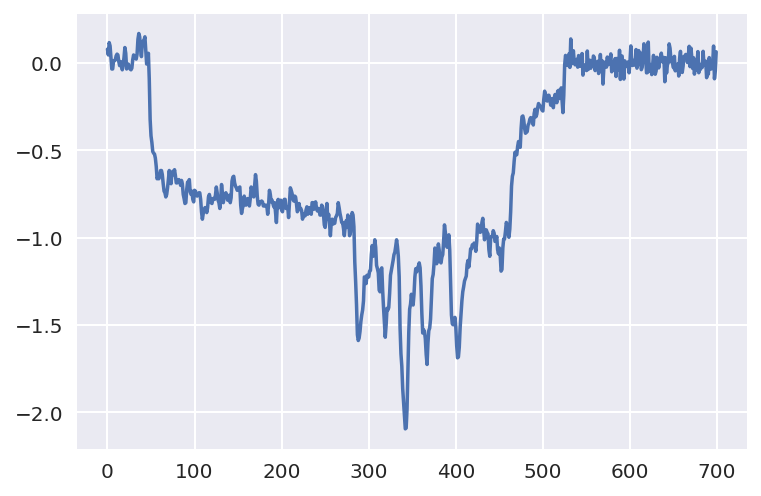

In [29]:
event_no = 1038

pyplot.plot(X_test[event_no])

np.set_printoptions( suppress=True, 
                    formatter= {'float': '{: 0.3f}'.format, "bool": '{:>6d}'.format} )

print("prediction:", results[event_no] )
print("answers:", Y_test[event_no] )

### Single Metric

Use a single evaluation metric to asses internally how well the model is going. For the metric, combine (1) test set, (2) labeled data from mixed set (3) proportions of the mixed sets. 
Distribute their properties equally. Remember that we want to utilise around 80% of the data

In [0]:
# a lot dublication here, but many metric estimates still have these functions 

def predictionConfidence(prediction) -> float:
    "estimates the probability for prediction to be correct"
    if len(prediction.shape) > 1:
        #vector implementation
        return np.apply_along_axis(arr=prediction, axis=1, func1d=predictionConfidence)
    else:
        return np.max(prediction) # softmax max

def predictionGetBarcodeNumber(predictions):
    "returns the barcode number from prediction vector"
    return oneHotToNumber(predictions)    
    
def predictionGetBarcodeLabel(predictions):
    "returns the barcode label from prediction vector"
    return oneHotToBarcode(predictions)

def indecesOfbest(predictions, keep = 0.8):
    "gives indeces of the best data, while keeping specified proportion of the data"
    prob = np.apply_along_axis(predictionConfidence, axis=1, arr = predictions)
    return prob.argsort()[ int(len(prob)*(1-keep)):]
    
def evaluateOnlyBest(x, y, keep=0.8, verbose = False):
    "evaluates the best predictions only"
    best = indecesOfbest( model.predict(x) , keep=keep)
    return model.evaluate(x=x[best], y=y[best], verbose = verbose)

def predictOnlyBest(x, y=None, keep=0.8, verbose = False):
    "runs prediction on the best data"
    predictions = model.predict(x, verbose=verbose)
    best = indecesOfbest( predictions, keep=keep)
    if y is None:
        return predictions[best]
    else: 
        return predictions[best], y[best]

In [0]:
evaluateOnlyBest(x = X_test.reshape(shapeX), y = Y_test, keep = 0.8)

[0.0935830519786501, 0.9873737373737373]

Measuring divergence from expected distribution is not straight forward. The general concept is called 
[statistical distance](https://en.wikipedia.org/wiki/Statistical_distance) and many ML people recommend using 
[KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). The latter is unsuitable for our task because it is designed for continuous distribution and it is not even a metric. 

Instead, we define a simple ratio of samples that fall into correct distribution. 
Denote measured distribution as $\vec x$ and our prior distribution $\vec p$. Find the minimal distance between them:

$$ \min( \sum( \vec x - \lambda \vec p ) ) $$

where $\lambda$ is a free parameter that minimises the function. It is given by

$$\lambda = \frac{\vec x \cdot \vec p}{\vec p \cdot \vec p}$$

and the ratio of correct predictions then is 

$$cr = 1 - \frac{\sum( \vec x - \lambda \vec p)}{\sum x } $$


In [0]:
def countBarcodeLabels(barcodes):
    "counts all barcode labels and returns pd.Series with Barcode index"
    labels = np.array(['000', '001', '010', '011', '100', '101', '110', '111'])
    x_dist = pd.Series(barcodes).value_counts().sort_index()
    return x_dist.reindex(index=labels).fillna(0)


def evaluateDistribution(x, prior, keep = 0.8, verbose = False):
    predictions = predictOnlyBest(x, y=None, keep=keep, verbose = False)
    x_dist = countBarcodeLabels( predictionGetBarcodeLabel(predictions) )
    #print(x_dist)
    similarity = distributionMatch(
        x_dist=x_dist.drop(['wrong', 'wro'], errors='ignore'), prior=prior, verbose=False)
    
    if verbose:
        # print graphics
        pyplot.title("Similarity to prior: " + str(round(similarity,3)) ) 
        seaborn.barplot(x_dist.index, x_dist.values, palette="Set1")#, ax=ax)
        pyplot.ylabel("Detections");
        
    return similarity


def distributionMatchQd(x_dist, prior):
    ""
    x = np.array(x_dist) ; p = np.array(prior)
    lambd = np.dot(x, p) / np.dot(p, p)
    print("lambda", lambd )
    cr = 1 - np.sqrt( np.dot(x - lambd*p, x - lambd*p) ) / np.sqrt( np.dot(x, x) )
    return cr

from math import isclose

def distributionMatch(x_dist, prior, limts = [0.0,10.0], verbose = False):
    """
    Finds linear difference between two discrete distributions
    
    :param x_dist: distribution to test
    :param prior: prior known distribution to compare with 
    :param limits: search range for minimization - do not change
    :param verbose: give extra information
    :return: how close are the distributions: 1 - the same, 0 - maximum distance
    """
    x = np.array(x_dist) / np.sum(x_dist) 
    p = np.array(prior) / np.sum(prior)
    ep = 0.0000001
    def cr(l):
        return np.sum( np.abs(x - l*p))
    def dCR(l):
        return (cr(l+ep) - cr(l-ep))/(2*ep)
    
    def returnSeq():
        if verbose:
            print("lambda", lambd )
            print("cr", cr(lambd))
            tmp = np.array( list(map(lambda x: [x, cr(x)], np.arange(-0.5,10,0.01) )) )
            pyplot.plot(tmp[:,0],tmp[:,1])
            pyplot.plot(lambd,cr(lambd), "Xg")
        return 1- cr(lambd) / np.sum(x)
    
    a1 = dCR(limts[1])
    a2 = dCR(limts[0])
    b1 = cr(limts[1]) - a1*limts[1]
    b2 = cr(limts[0]) - a2*limts[0]
    lambd = - (b2-b1)/(a2-a1)
    
    if isclose( a1*lambd + b1 , cr(lambd), abs_tol=ep):
        return returnSeq()
    elif dCR(lambd) < 0 : # not there jet - narrow the limit 
        return distributionMatch(x, p, limts = [lambd, limts[1]], verbose = verbose)
    else: 
        return distributionMatch(x, p, limts = [limts[0],lambd], verbose = verbose)
    
# testing
#tmp1 = [1,0,1,0]
#tmp2 = [2,0,2,0]
#print("=1=" , distributionMatch(tmp1, tmp2) )
#print("=2=" , distributionMatch2(tmp1, tmp2 , verbose = True) )


In [0]:
# evaluate single metric 

def singleMetric(keep = 0.8, verbose = True):
    # part 1: test set
    test_set = evaluateOnlyBest(x = X_test.reshape(shapeX), y = Y_test, keep = keep)[1]
    # part 2: mixed set - independant experimetn
    data = datasetTestMix[datasetTestMix.nbell_barcode<8] 
    data_X = prepareTraces(data)
    data_Y = np.vstack( data.nbell_barcode.apply(numberToOneHot)  )
    mixed_set = evaluateOnlyBest(x = data_X.reshape(shapeX), y = data_Y, keep = keep)[1]
    # part 3: distribution match
    d1 = evaluateDistribution( 
        prepareTraces( datasetTestEven[datasetTestEven.Filter] ).reshape(shapeX), 
        prior = [1,0,1,0,1,0,1,0],
        verbose = False, keep = keep
    )
    d2 = evaluateDistribution( 
        prepareTraces( datasetTestOdd[datasetTestOdd.Filter] ).reshape(shapeX), 
        prior = [0,1,0,1,0,1,0,1],
        verbose = False, keep = keep
    )
    d3 = evaluateDistribution( 
        prepareTraces( datasetTestMix[datasetTestMix.Filter] ).reshape(shapeX), 
        prior = [1,1,1,1,1,1,1,1],
        verbose = False, keep = keep
    )
    distribution_set = np.mean([d1,d2,d3])
    score = np.mean([test_set,mixed_set,distribution_set])
    # visualise
    if verbose:
        print("-------------------------------")
        print("Test  set Precission   : {:.1f}%".format(100*test_set))
        print("Mixed set Precission   : {:.1f}%".format(100*mixed_set))
        print("Distribution similarity: {:.1f}%".format(100*distribution_set))
        print("===============================")
        print("Single Metric          : {:.1f}%".format(100*score))
        print("-------------------------------")
    
    return score

singleMetric(keep = 0.8);


-------------------------------
Test  set Precission   : 98.7%
Mixed set Precission   : 95.9%
Distribution similarity: 82.0%
Single Metric          : 92.2%
-------------------------------


---

## Precision vs Data remaining

In this problem we are balancing between Precision of our predictions and Recall (or how much data we keep). Therefore, it is a useful comparison tool

In [0]:
# make sure probability estimators are ready

def estimatePrecisionVsDrop(y_true, x_test):
    "Estimates precision and recalland returns in a table"
    
    predictions_raw = model.predict(x_test.reshape(shapeX))
    
    prediction_barcodes = predictionGetBarcodeNumber(predictions_raw)
    prediction_confidence = predictionConfidence(predictions_raw)
    y_true_numbers = predictionGetBarcodeNumber(y_true)
    # put all in one table
    data = pd.DataFrame({
        "prediction":prediction_barcodes,
        "label": y_true_numbers,
        "confidence": prediction_confidence,
        "correct": prediction_barcodes == y_true_numbers
    }).sort_values(by=['confidence'])
    
    length = len(data)
    
    def precission(drop):
        return data.correct[drop:].sum() / (length-drop)
    def recall(drop):
         return data.correct[drop:].sum() / (length)
    def data_remaining(drop):
        return (0.0+length-drop) / length
    
    index = range(0,length, int(length/1000))
    
    return pd.DataFrame({
        "Precission": list([precission(i) for i in  index]),
        "Recall":     list([recall(i) for i in index]),
        "Remaining":  list([data_remaining(i) for i in  index])

    })

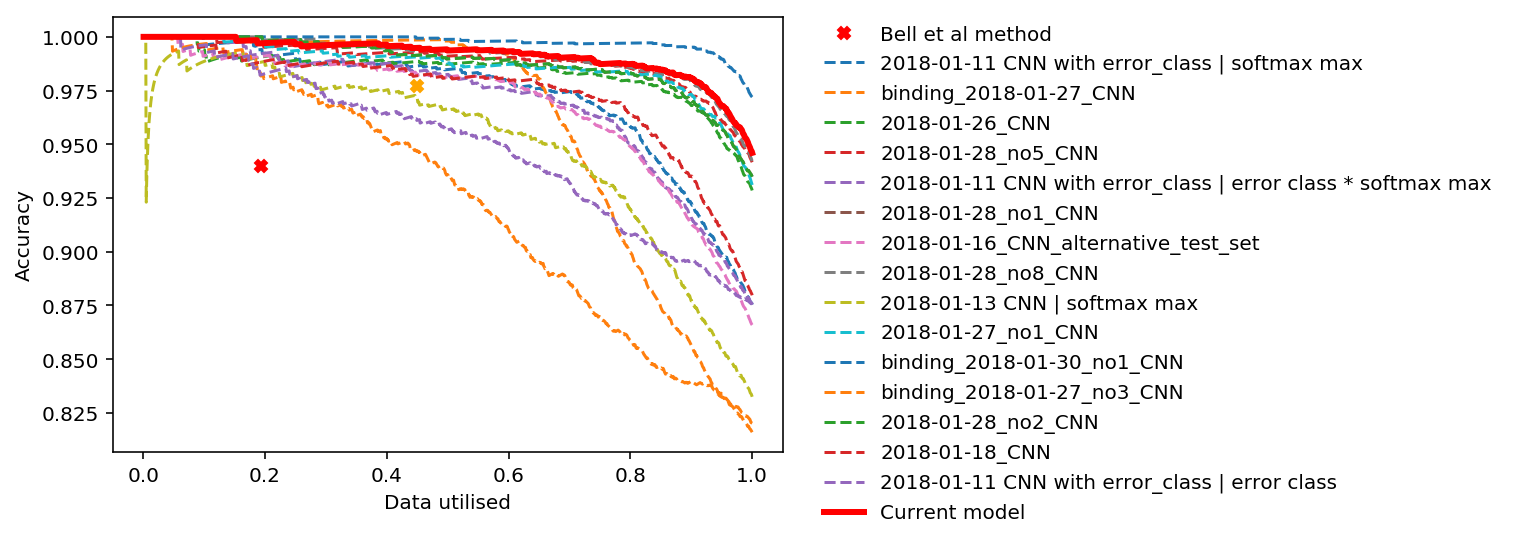

In [0]:
# evaluation

data = estimatePrecisionVsDrop(Y_test,  X_test)
#data = estimatePrecisionVsDrop(Y_dev,  X_dev)

#nbell results for comparison
ds_nbell = dataset[dataset.Filter & (dataset.nbell_barcode<8)]
pyplot.plot(
    len(ds_nbell) / len(dataset[dataset.Filter]),
    ((ds_nbell.barcode.apply(barcodeToNumber) ) == ds_nbell.nbell_barcode).sum() / len(ds_nbell),
    "Xr",
    label='Bell et al method'
)

# human results for comparison (from paper)
pyplot.plot([0.45], [0.977], "X", color='orange')
# old comparison files
import glob, os
compare_with_files = glob.glob("models/comparison/*.csv")
for file in compare_with_files:
    data2 = pd.read_csv(file)
    pyplot.plot(
        data2.Remaining, data2.Precission, 
        '--',
        label=os.path.basename(file)[:-4]
    )

# current model plot on top
pyplot.plot(
    data.Remaining, data.Precission, 
    linewidth = 3.0, color='red',
    label='Current model'
)

pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
#pyplot.ylim([0.90, 1.0])
pyplot.xlabel("Data utilised")
pyplot.ylabel("Accuracy");


In [0]:
# Optional: save model for future comparison
name = "2018-04-03_no1_barcode"
data.to_csv("models/comparison/"+name+".csv")

---
## ROC curves


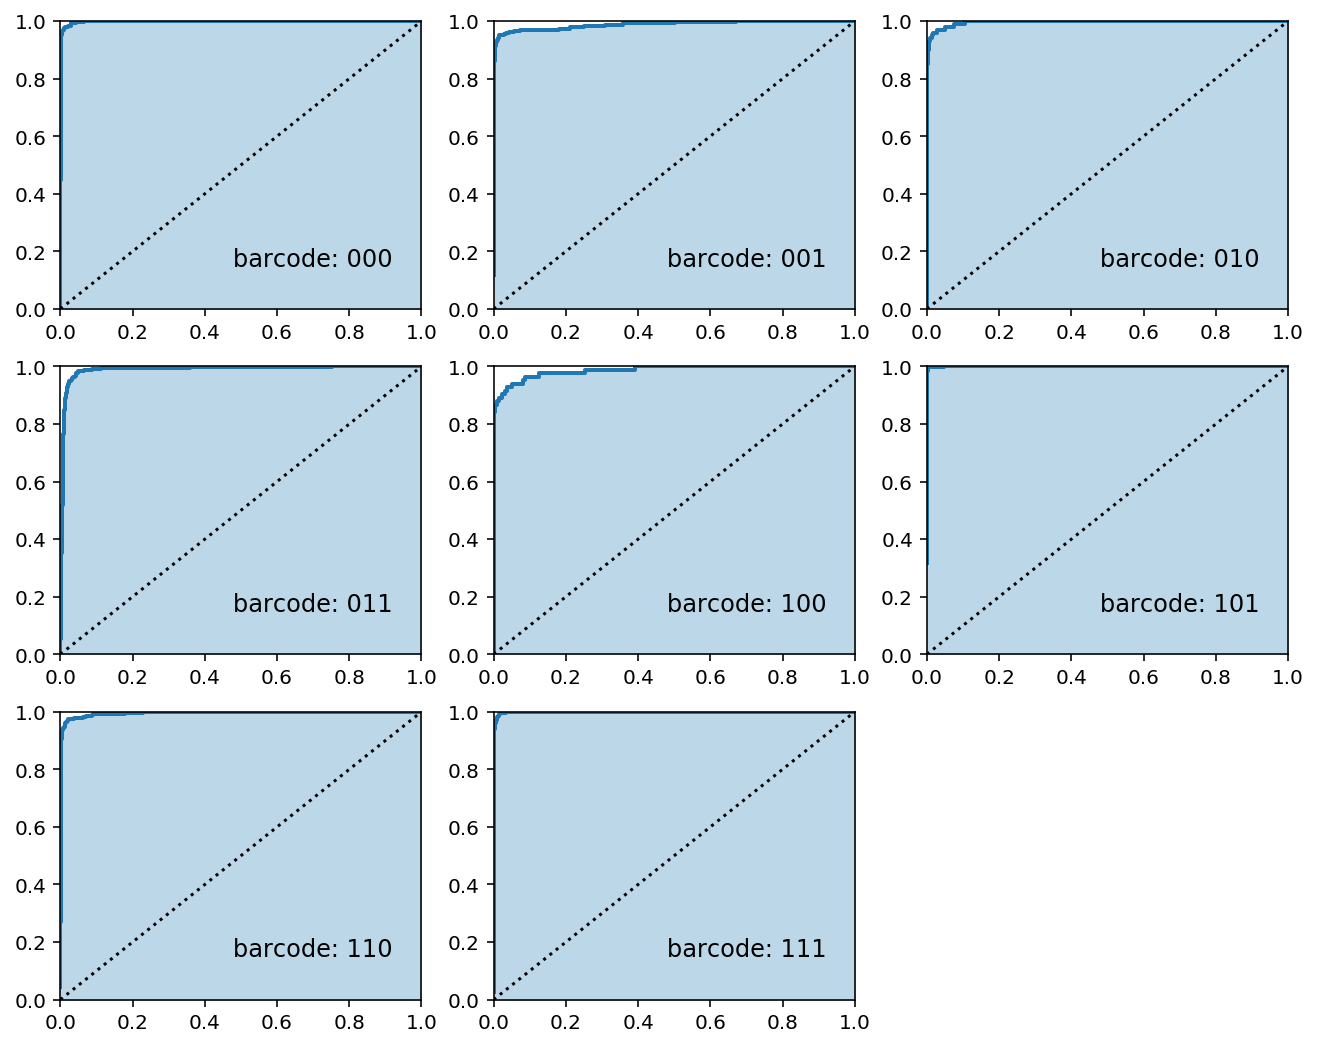

In [0]:
# run on test set

preditions = model.predict(x=X_test.reshape(shapeX))

def roc_curve_for_barcode(barcode):
    idx = np.where(barcode == labels)[0][0]
    y_true = Y_test[:,idx]
    y_pred = preditions[:,idx]
    return sklearn.metrics.roc_curve(y_true, y_pred)

pyplot.figure(figsize=(11,9))

for i in range(8):
    fpr, tpr, thresholds = roc_curve_for_barcode(labels[i])
    pyplot.subplot(3, 3, i+1)
    pyplot.fill_between(x=fpr, y1=tpr, y2=0, color = '#BCD8E8')
    pyplot.plot(fpr, tpr, linewidth=2)
    pyplot.xlim([0,1])
    pyplot.ylim([0,1])
    pyplot.plot([0,1],[0,1], linestyle='dotted', color='black')
    pyplot.text(0.7,0.15, "barcode: " + labels[i], horizontalalignment='center', fontsize=12)

pyplot.savefig('images/ROC_curves_barcodes.pdf')

---

## Error matrix

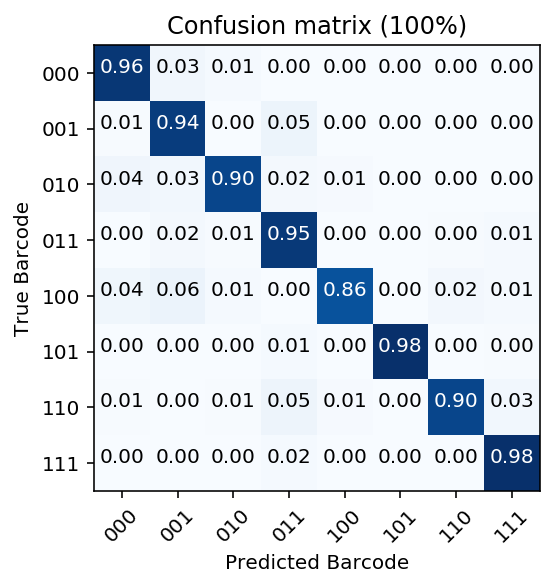

In [0]:
# Error matrix

from sklearn.metrics import confusion_matrix
import itertools
#predictions = model.predict(x = X_test.reshape(shapeX))


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    "This function prints and plots the confusion matrix."
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    #pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True Barcode')
    pyplot.xlabel('Predicted Barcode')
    
    
def barcode_error_matrix(keep, title):
    """
    :param keep: amount of data to keep, discarding low quality predictions
    :param title: read the label on the tin
    :return: error matrix plot
    """
    predictions, y = predictOnlyBest(x=X_test.reshape(shapeX), y=Y_test, keep=keep)

    barcodeLabels = ['000','001','010','011','100','101','110','111']
    confusionMatrix = confusion_matrix(
        list(map(oneHotToBarcode, y)), 
        list(map(oneHotToBarcode, predictions)), 
        labels=barcodeLabels
    )
    return plot_confusion_matrix(confusionMatrix, classes=barcodeLabels, title=title)
    
    
# pyplot.figure(figsize=(8, 6))
barcode_error_matrix(keep = 1.0, title='Confusion matrix (100%)')

#export fig
# pyplot.figure(figsize=(5, 4))
# barcode_error_matrix(keep = 1.0, title='')
# pyplot.savefig('images/barcode_confusion_matrix.pdf')

Ok, this is rather complicated result. It looks like the worst performance was for '100' barcode. It could be due to rare event sampling, but Precision in low as well, suggesting that it is lack of training data. 

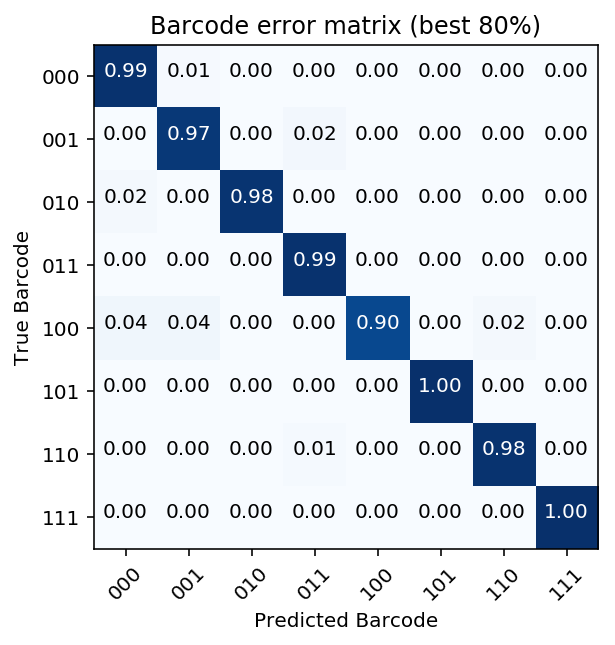

In [0]:
pyplot.figure(figsize=(4.6, 4.6))
barcode_error_matrix(keep = 0.8, title='Barcode error matrix (best 80%)')
pyplot.tight_layout()
pyplot.savefig('images/barcode_confusion_matrix_best_80.png', dpi=140)

--- 

## Distribution tests 

NBell [1] have performed experiments with multiple barcodes in a mixture. Here, there is no labels to compare against, but instead we know rough ratios between different barcodes. Note that these experiments are not very precise. 

In [0]:
# function to compare model with NBell results

def distributionComparisonWithNBell(dataset, prior, keep, distance = False, legend = True):
    "compare NBell predictions with CNN"
    #Nbell
    nbell_ds = dataset[dataset.nbell_barcode < 8]
    nbell_barcodes = nbell_ds.nbell_barcode.apply(lambda x: "{0:0>3b}".format(int(x)))
    nbell_counts = countBarcodeLabels(nbell_barcodes)
    
    #CNN
    traces = prepareTraces( dataset ).reshape(shapeX)
    predictions = predictOnlyBest(x=traces, verbose=False, keep=keep)
    cnn_counts = countBarcodeLabels(predictionGetBarcodeLabel(predictions))
    
    # Art
    width = 0.25
    index = np.arange(1,9)
    labels = np.array(['000', '001', '010', '011', '100', '101', '110', '111'])
    #background prior
    pyplot.bar(
        x = index , 
        height = prior / np.sum(prior), 
        width = 1,
        color = '#B2CDF9',
        label = 'Prior'
    )
    pyplot.bar(
        x = index + width/2, 
        height = nbell_counts.values/np.sum(nbell_counts.values) ,
        width = width,
        label = 'NBell'
    )
    pyplot.bar(
        x = index - width/2, 
        height = cnn_counts.values/np.sum(cnn_counts.values) ,
        width = width,
        label = "CNN"
    )
    if distance:
        nbell_dist = distributionMatch(x_dist=nbell_counts, prior=prior)
        cnn_dist = distributionMatch(x_dist=cnn_counts, prior=prior)
        pyplot.title("Distance CNN: {:.3f}; NBell: {:.3f}".format(cnn_dist,nbell_dist))
    
    pyplot.xlim([0.5,8.5])
    pyplot.xticks(index, labels)
    if legend: pyplot.legend( loc=3)



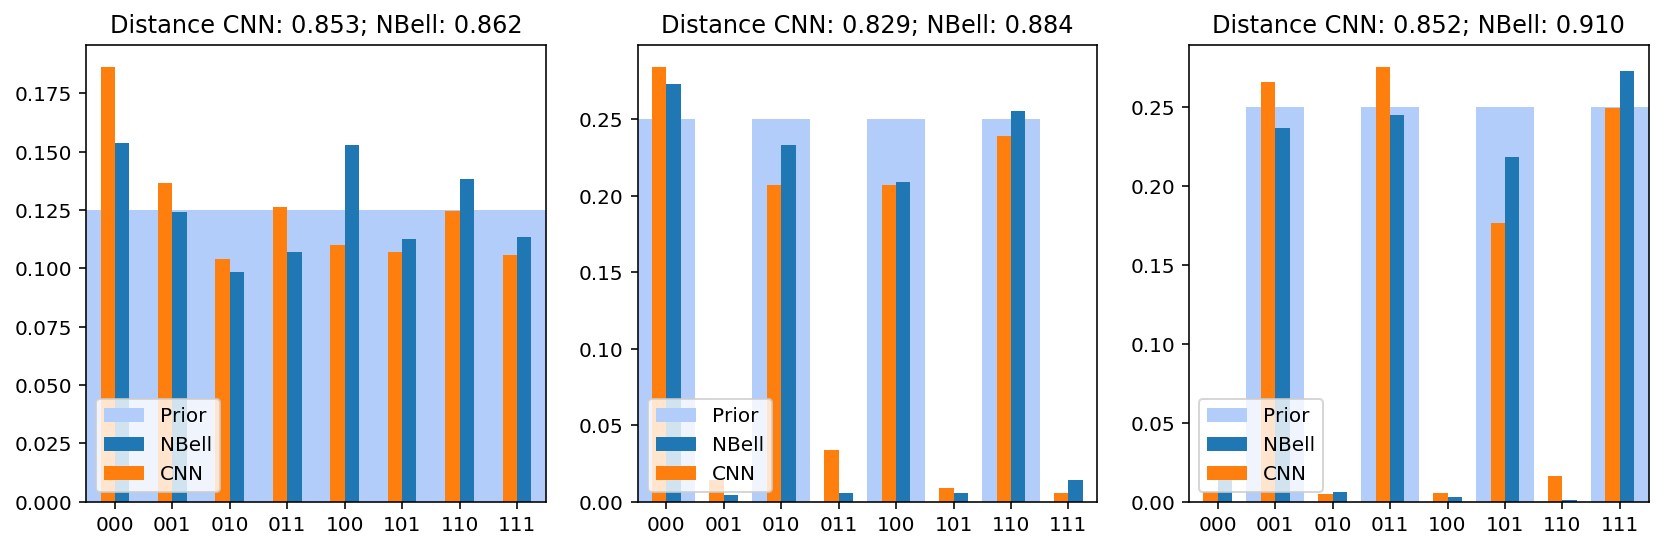

In [0]:
# Plot distributions for all the data

keep = 1.0; # how much data to evaluate with 

pyplot.figure(figsize=[14,4.2])

pyplot.subplot(1,3,1)
distributionComparisonWithNBell(
    dataset = datasetTestMix[datasetTestMix.Filter],
    prior = np.array([1,1,1,1,1,1,1,1]),
    keep = keep , distance = True     
)

pyplot.subplot(1,3,2)
distributionComparisonWithNBell(
    dataset = datasetTestEven[datasetTestEven.Filter],
    prior = np.array([1,0,1,0,1,0,1,0]),
    keep = keep   , distance = True   
)

pyplot.subplot(1,3,3)
distributionComparisonWithNBell(
    dataset = datasetTestOdd[datasetTestOdd.Filter],
    prior = np.array([0,1,0,1,0,1,0,1]),
    keep = keep  , distance = True    
)


The closer the distance is to 1, the better. 

Here, QuipuNet is slightly worse that the NBell method. However, this might as well be within the error range because we don't know the accuracy of the initial distributions.

Evaluated on the same data as NBell, QuipuNet gives slightly smaller distance:

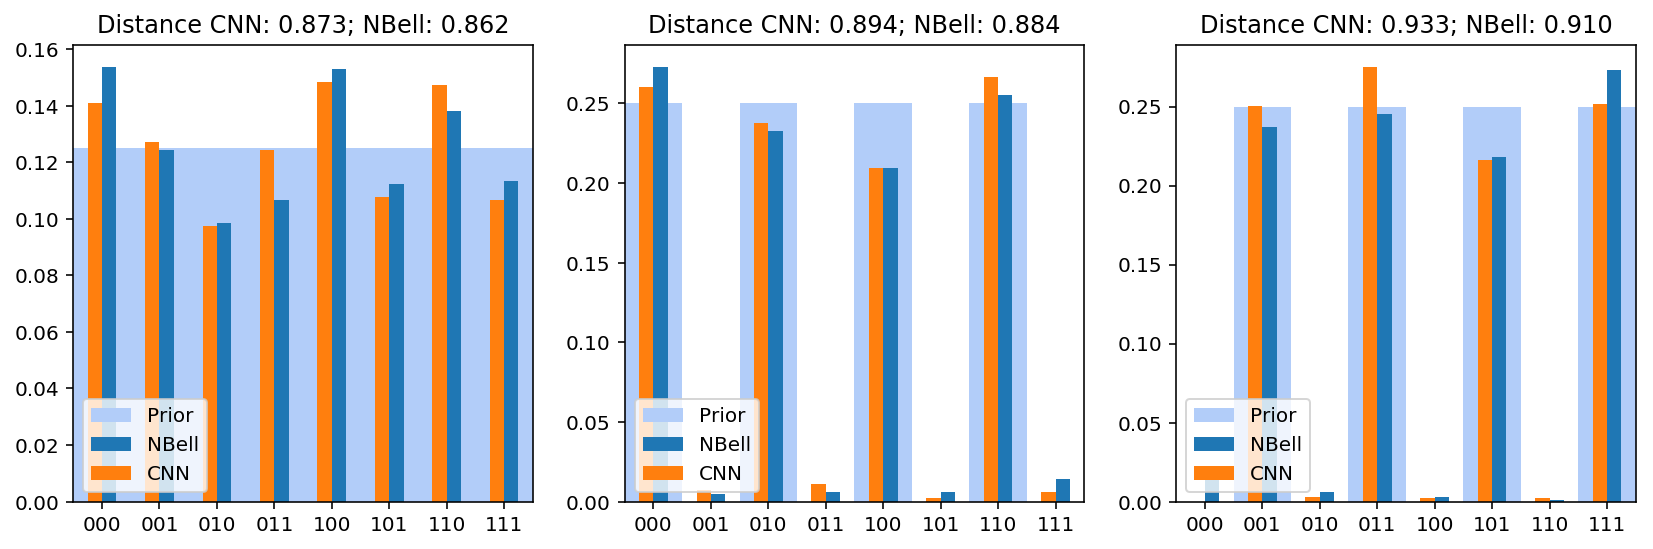

In [0]:
# Plot distributions for all NBell data only

keep = 1.0; # how much data to evaluate with 

pyplot.figure(figsize=[14,4.2])

pyplot.subplot(1,3,1)
distributionComparisonWithNBell(
    dataset = datasetTestMix[datasetTestMix.Filter & (datasetTestMix.nbell_barcode < 8)],
    prior = np.array([1,1,1,1,1,1,1,1]),
    keep = keep , distance = True     
)

pyplot.subplot(1,3,2)
distributionComparisonWithNBell(
    dataset = datasetTestEven[datasetTestEven.Filter & (datasetTestEven.nbell_barcode < 8)],
    prior = np.array([1,0,1,0,1,0,1,0]),
    keep = keep   , distance = True   
)

pyplot.subplot(1,3,3)
distributionComparisonWithNBell(
    dataset = datasetTestOdd[datasetTestOdd.Filter & (datasetTestOdd.nbell_barcode < 8)],
    prior = np.array([0,1,0,1,0,1,0,1]),
    keep = keep , distance = True    
)

The improvement is consistent with our expectations for QuipuNet performance. 

--- 

## Error inspection

Manually inspect the mistakes that QuipuNet makes

In [0]:
# TEST: select only the ones that were interpreted as 001, but were 101

X, Y = X_test, np.array(Y_test_labels)
predictions = model.predict(x = X.reshape(shapeX))
confidence = predictionConfidence(predictions)
prediction_barcode = predictionGetBarcodeLabel(predictions)

selection =  (Y != prediction_barcode)
#print("Cases 001 -> 101 fopund:", selection.sum() )


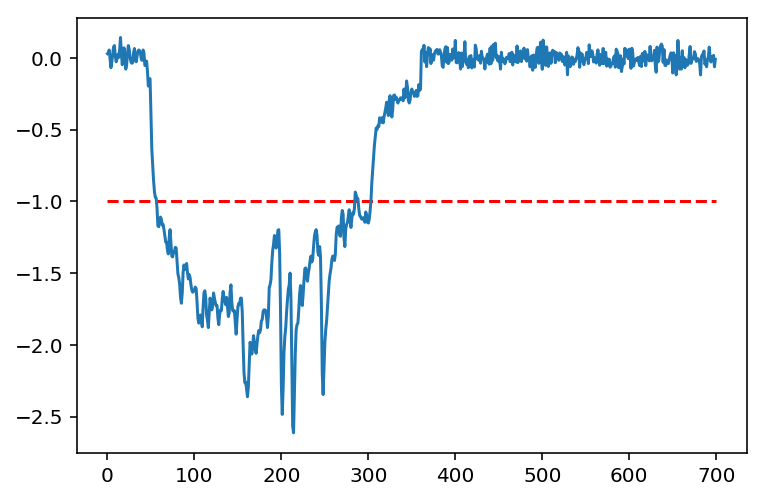

rndId:       556
Prediction:  111
Confidence:  0.5827971
Label:       110
Correct:     False
label vec  : ['000 ' '001 ' '010 ' '011 ' '100 ' '101 ' '110 ' '111 ']
vector:      [ 0.000  0.009  0.009  0.373  0.000  0.001  0.025  0.583]
Bound?:      False


In [0]:
# show random sapmple from selection

rndId = np.random.choice( np.arange(len(selection))[selection] )

pyplot.plot([0,700],[-1]*2, 'r--' )
pyplot.plot( X[rndId] )
pyplot.show()

def formatSrt(text):
    if len(text) >= 4:
        return text[:4]
    else:
        return text + (' ' *(4-len(text)))
        
np.set_printoptions( suppress=True, 
                    formatter= {'float': '{: 0.3f}'.format, "bool": '{:>6d}'.format} )

print("rndId:      ", rndId)
print("Prediction: ", prediction_barcode[rndId] )
print("Confidence: ", confidence[rndId] )
print("Label:      ", Y[rndId] )
print("Correct:    ", Y[rndId] == prediction_barcode[rndId] )
print("label vec  :", np.array( list(map(formatSrt, labels))) )
print("vector:     ", predictions[rndId] )
print("Bound?:     ", testSet.iloc[rndId].Bound)
if not np.isnan( testSet.iloc[rndId].nbell_barcode ):
    print("nbell_barcode:", numberToBarcode( testSet.iloc[rndId].nbell_barcode))

---

# Plot example predictions (Fig.3)

In [0]:
model_sensing = keras.models.load_model("/home/kmisiunas/Documents/Quipu/models/binding_metric972_2018-01-30_no1.h5")

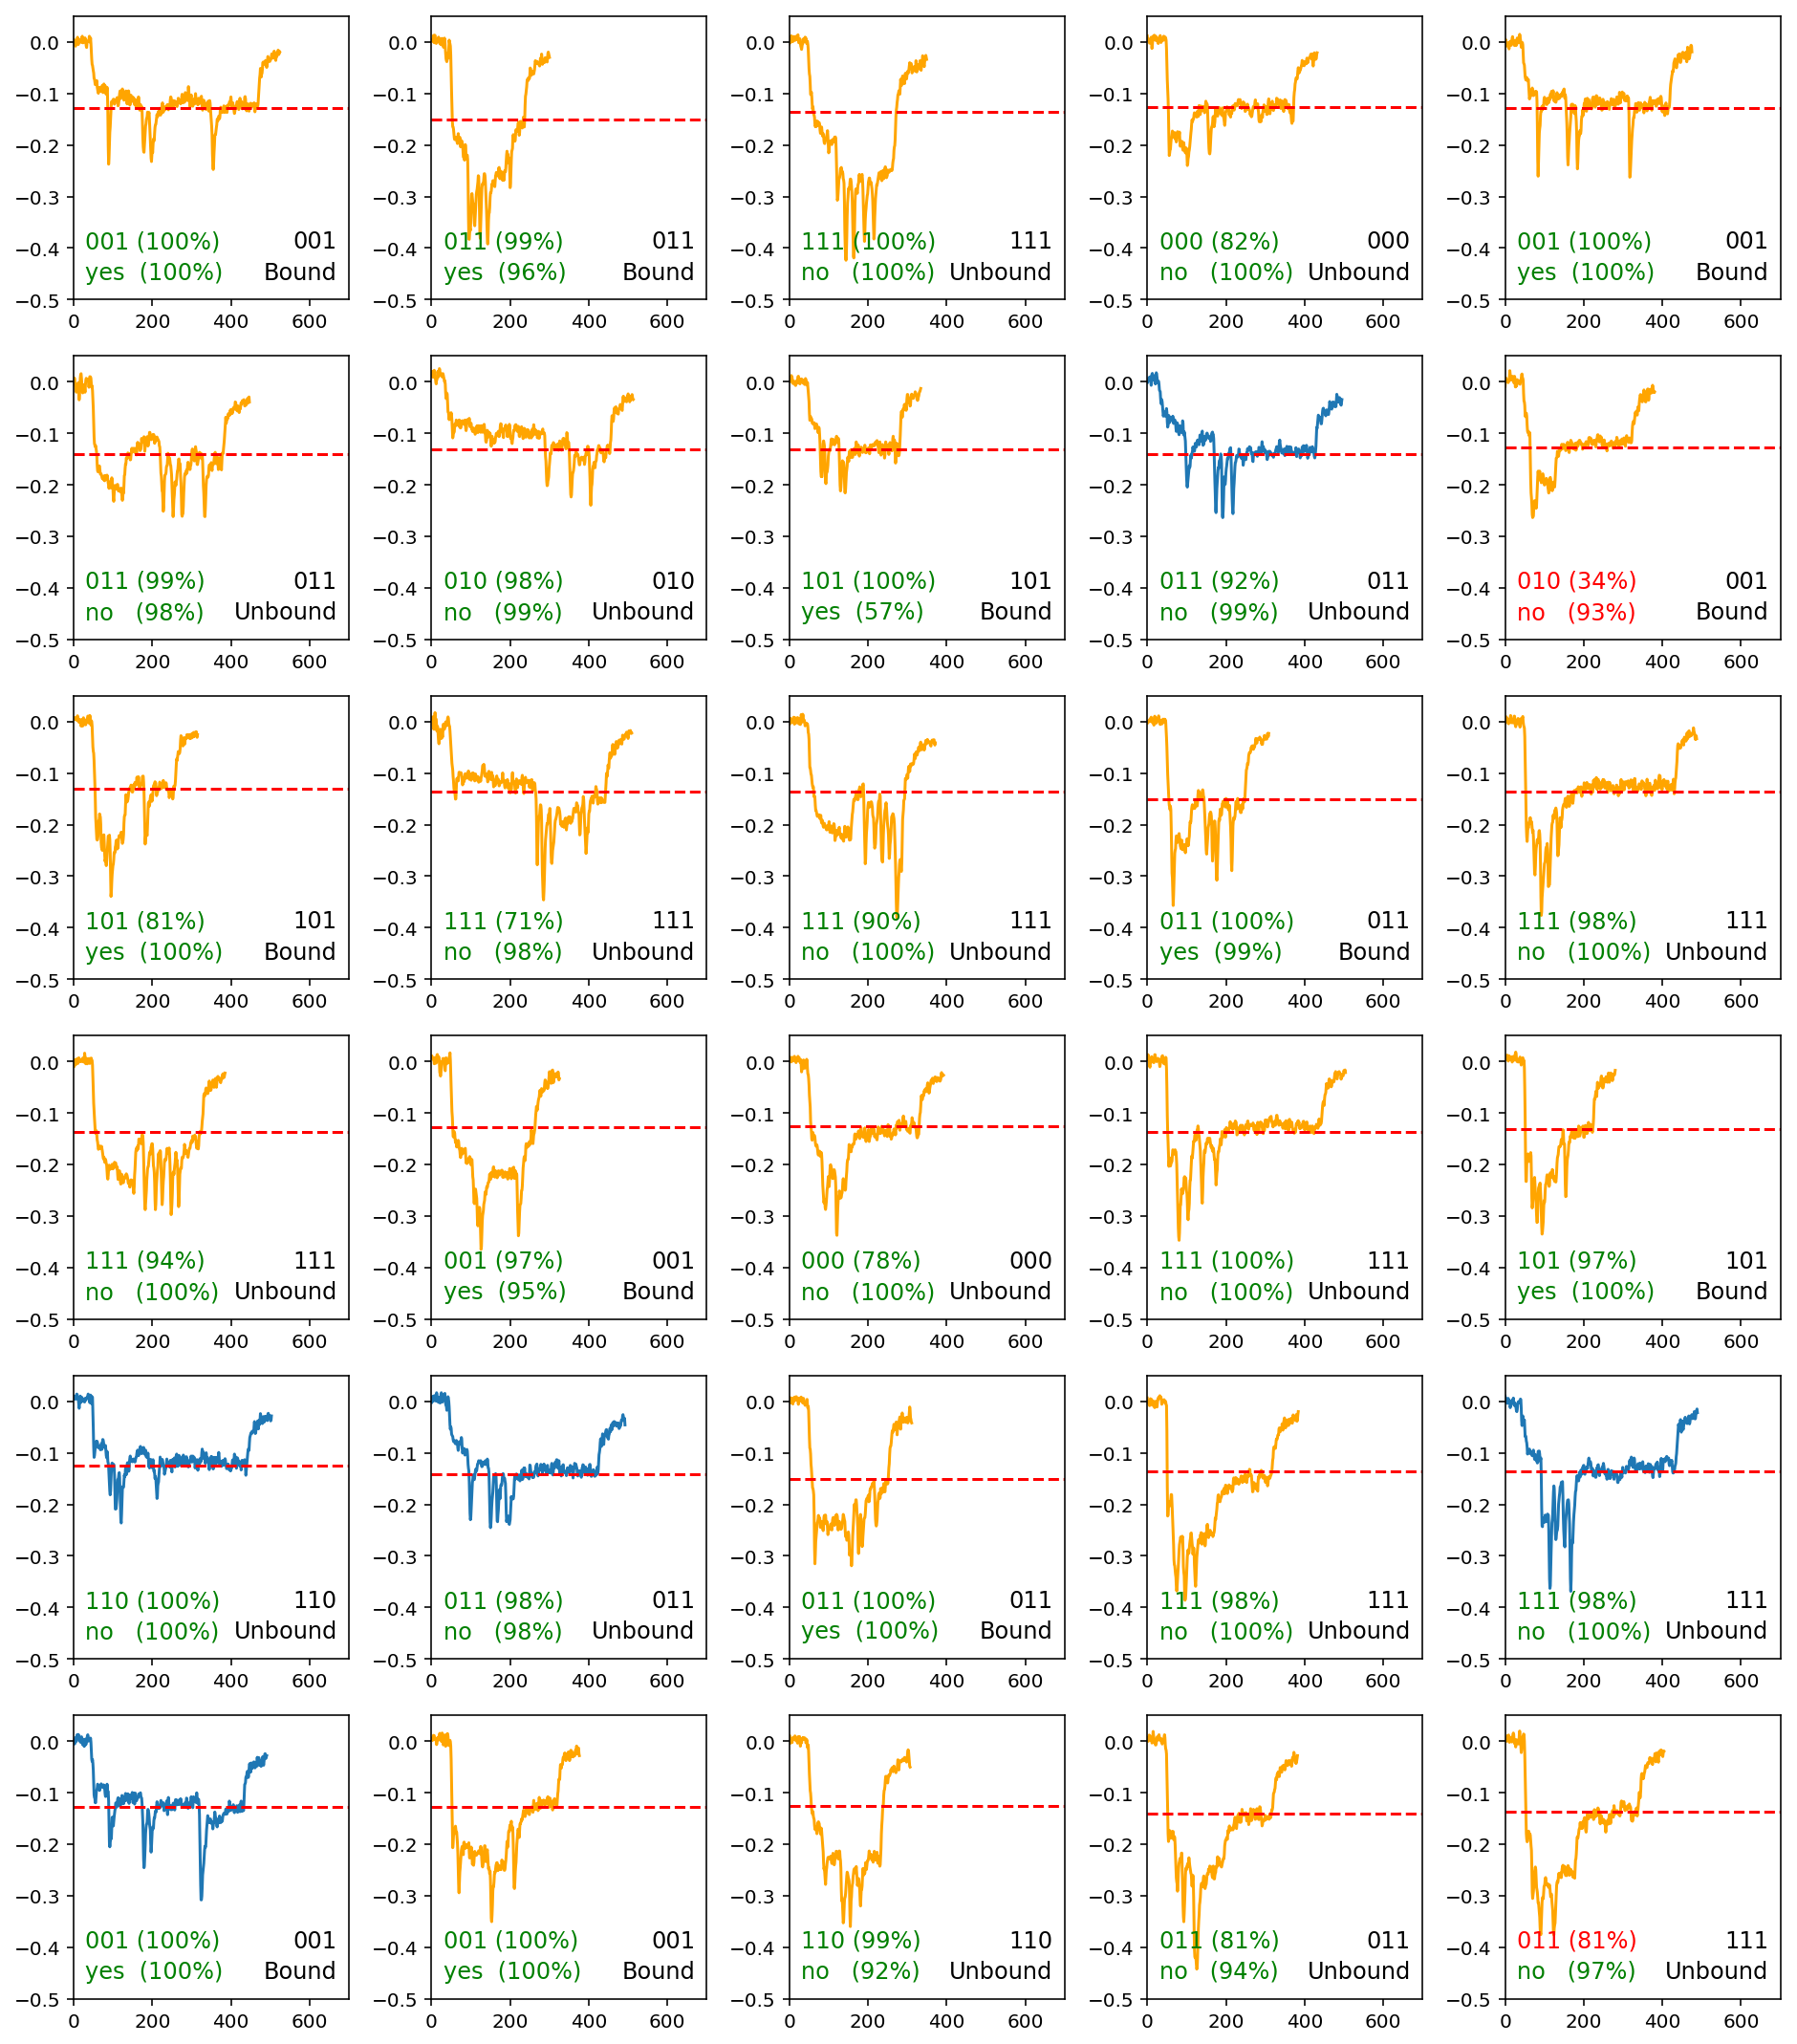

In [0]:
pyplot.figure(figsize=[16,18])
pyplot.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.2)

data = testSet

examples_included = data[data.Filter].sample(5*6)


predict_barcode = model.predict(prepareTraces(examples_included).reshape(shapeX))
predict_barcode_label = predictionGetBarcodeLabel(predict_barcode)
predict_barcode_confidence = predictionConfidence(predict_barcode)

predict_sensing = model_sensing.predict(prepareTraces(examples_included).reshape(shapeX))

# position configs
pos_true_x = 670.0
pos_true_y = -0.40
dy = -0.06
pos_pred_x = 30.0

for i in range(5*6):
    one = examples_included.iloc[i]
    pyplot.subplot(6,5,i+1)
    if one.nbell_barcode < 8:
        pyplot.plot(one.trace)
    else:
        pyplot.plot(one.trace, color='orange')
    # labels
    pyplot.text(pos_true_x, pos_true_y, one.barcode, fontsize=12, horizontalalignment='right')
    bound_label = "Bound" if one.Bound else "Unbound"
    pyplot.text(pos_true_x, pos_true_y + dy, bound_label, fontsize=12, horizontalalignment='right')

    # preditions: barcode
    color = 'green' if predict_barcode_label[i] == one.barcode else 'red'
    barcode_cnn_label = predict_barcode_label[i] + " ({:0.0f}%)".format(100*predict_barcode_confidence[i])
    pyplot.text(pos_pred_x, pos_true_y, barcode_cnn_label, fontsize=12, horizontalalignment='left', color= color)

    # prediction: sensing region
    color = 'green' if np.round(predict_sensing[i]) == one.Bound else 'red'
    barcode_cnn_label = 'yes' if predict_sensing[i] > 0.5 else 'no '
    confidence = np.max([ predict_sensing[i], 1.0-predict_sensing[i] ])
    barcode_cnn_label = barcode_cnn_label + "  ({:0.0f}%)".format(100*confidence)
    pyplot.text(pos_pred_x, pos_true_y+dy, barcode_cnn_label, fontsize=12, horizontalalignment='left', color= color)

    
    # other styling
    pyplot.plot([0,700], [one.UnfoldedLevel]*2, 'r--')
    pyplot.ylim([-0.5, 0.05])
    pyplot.xlim([0, 700])
    
pyplot.savefig('images/extra_examples.pdf');  

---

# Dataset size vs precision

A reviewer asked to show how accuracy changes with the training set size. We reduce the training set of barcode '011', while keeping all the data for the other barcodes. Then train the model as before and evaluate on test set. Then repeat for a different number of training samples.

In [0]:
def createTrainingDataset(size):    
    barcode = '011'
    
    sel = trainSet[trainSet.barcode == barcode].sample(size)
    subset = pd.concat([
        trainSet[trainSet.barcode != barcode],
        sel
    ])
    
    
    X_train = prepareTraces( subset )   
    Y_train_barcode = np.vstack( subset.barcode.values )

    Y_train = barcodeToOneHot(Y_train_barcode)
    
    weights = class_weight.compute_class_weight('balanced', labels, Y_train_labels)

    
    return X_train, Y_train, weights

In [0]:
def createQuipuNetModel():
    input_trace = Input(shape=(hp["traceLength"],1), dtype='float32', name='input')

    x = Conv1D(64, 7, padding="same")(input_trace)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = Conv1D(64, 7, padding="same")(x)
    x = BatchNormalization(axis=1)(x) 
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.25)(x)

    x = Conv1D(128, 5, padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = Conv1D(128, 5, padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.25)(x)

    x = Conv1D(256, 3, padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = Conv1D(256, 3, padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)


    output_barcode = Dense(hp['barcodes'], activation='softmax', name='output_barcode')(x)
    model = Model(inputs=input_trace, outputs=output_barcode)

    model.compile(
        loss = 'categorical_crossentropy', 
        optimizer = Adam(lr=0.001),
        #optimizer = keras.optimizers.RMSprop(lr=0.001), # poor performance
        #optimizer = keras.optimizers.Nadam(lr=0.002),
        metrics = ['accuracy']
    )
    return model

shapeX = (-1, hp["traceLength"],1); 
shapeY = (-1, hp['barcodes'])
tensorboard, history = resetHistory()

In [0]:
def trainModel():
    lr = 0.001
    for n in range(0,200):
        # data augmentation
        X = np.repeat(X_train, 1, axis=0) # make copies
        Y = np.repeat(Y_train, 1, axis=0)
        X = augment.magnitude(X, std = 0.08) 
        X = augment.stretchDuration(X, std=0.1, probability=0.3)
        X = augment.addNoise( X, std = 0.08) 
        # Learning rate decay
        lr = lr*0.97
        model.optimizer.lr.assign(lr)

        # Fit the model
        out_history = model.fit( 
            x = X.reshape(shapeX), 
            y = Y.reshape(shapeY), 
            batch_size=32, shuffle = True,
            initial_epoch = n,  epochs=n+1, #nextEpochNo(),
            class_weight = weights, # consider commenting it out
            callbacks = [tensorboard], verbose = 0
        )


In [0]:
def assessModel(n):
    barcode = '011'
    predictions = model.predict(x=X_test.reshape(shapeX), verbose = False)
    predictions_labels = predictionGetBarcodeLabel(predictions)
    
    mask_precision = predictions_labels == barcode
    mask_recall = np.array(Y_test_labels) == barcode
    
    recall = predictions_labels[mask_recall] == np.array(Y_test_labels)[mask_recall]
    precision = predictions_labels[mask_precision] == np.array(Y_test_labels)[mask_precision]
    
    
    return {
        "n": n, 
        "precision_n": np.sum(precision), # correct precision
        "recall_n": np.sum(recall), # correct recall
        "precision_total": len(precision), # no of attempted guesses 
        "recall_total": len(recall),  # no of 011 barcodes in test set 
        "precision_all_n": np.sum( predictions_labels  == np.array(Y_test_labels) ), # tootal number of correct events
        "testset_total": len(Y_test_labels), # total test size   
        "precision" :  np.sum(precision)/  len(precision),
        "recall" :  np.sum(recall)/  len(recall),
    }

In [0]:
output = []

def accuracyForDatasetSize(n):
    
    global model, X_train, Y_train, weights
    
    start_time = time.time()
    
    model = createQuipuNetModel()
    
    X_train, Y_train, weights = createTrainingDataset(n)
    
    trainModel()
    
    ans = assessModel(n)
    
    print("===   N=",n,",  time=", (time.time()- start_time)/60 , "(min)   ===")
    
    print("N={}, Precision={:.3f}, Recall={:.3f}".format(n, ans['precision'], ans['recall']))
    
    output.append(ans)
    
    # plot!! 
    
    tmp = pd.DataFrame(output)
    
    tmp.to_csv('sweep/no_of_samples/backup.csv')
    
    pyplot.figure(figsize=[4,3])
    pyplot.plot(tmp.n, tmp.precision)
    pyplot.plot(tmp.n, tmp.recall)
    pyplot.show()
    

In [0]:
# run (takes ~3days)

ns = [50,100,150,200,300,400,500,700,1000,1500,2000,2500,3000,3500,4000,4500,5000,6000,7000,9000,11000,13000,15000]

for n in ns:
    accuracyForDatasetSize(n)
    

In [0]:
# save

pd.DataFrame(output).to_csv('sweep/no_of_samples/2018-05-24_barcode.csv')


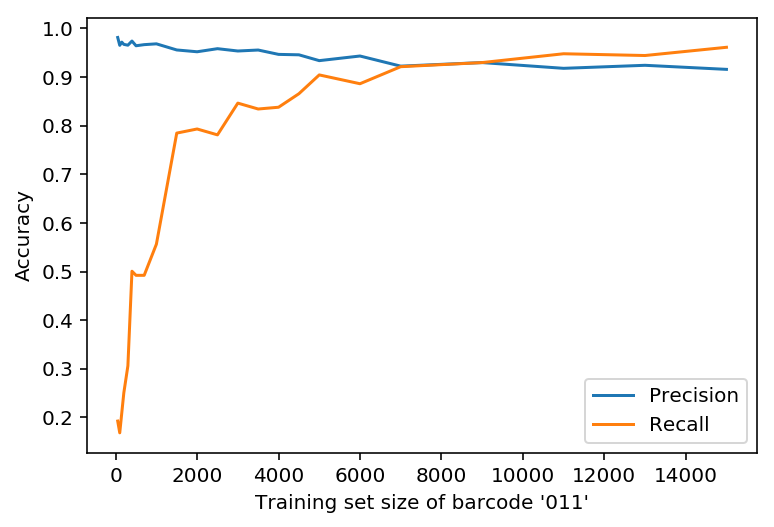

In [0]:
output_pd = pd.read_csv('sweep/no_of_samples/2018-05-24_barcode.csv')

pyplot.plot( output_pd.n, output_pd.precision , label='Precision')
pyplot.plot( output_pd.n, output_pd.recall , label='Recall')
pyplot.legend()
pyplot.xlabel("Training set size of barcode '011'")
pyplot.ylabel("Accuracy");